In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as D

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import trainer
from trainer import device

In [128]:
import os
import PIL.Image

class ImageDataset(D.Dataset):
    def __init__(self, path, transform=None):
        super().__init__()
        self.path = path
        self.files = os.listdir(path)
        self.transform = transform
    def __len__(self):
        return len(self.files)
    def __getitem__(self, idx):
        img = PIL.Image.open(self.path + "/" + self.files[idx])
        if self.transform:
            img = self.transform(img)
        return img, img

In [111]:
def display(img):
    plt.figure(figsize=(2,2))
    plt.imshow(img.permute(1,2,0))
    plt.axis('off')

def display2(img1, img2):
    plt.figure(figsize=(4,2))
    f, ax = plt.subplots(1, 2)
    ax[0].imshow(img1.permute(1,2,0))
    ax[1].imshow(img2.permute(1,2,0))
    ax[0].axis('off')
    ax[1].axis('off')

In [158]:
import torchvision.transforms as T

def img_resize(img):
    img = T.functional.to_tensor(img)
    img = T.functional.resize(img, 256, antialias=False)
    img = T.functional.pad(img, 128, padding_mode='edge')
    img = T.functional.center_crop(img, 256)
    return img

dataset = ImageDataset('../img_align_celeba', transform=img_resize)

In [133]:
class FaceNet(nn.Module):
    def __init__(self, n_hidden=128, n_embed=256):
        super().__init__()
        assert(n_hidden % 8 == 0)
        # encoder is following VGG-11
        self.encoder = nn.Sequential(
            # 256^2 => 128^2
            nn.Conv2d(3, n_hidden//8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 128^2 => 64^2
            nn.Conv2d(n_hidden//8, n_hidden//4, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 64^2 => 32^2
            nn.Conv2d(n_hidden//4, n_hidden//2, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(n_hidden//2, n_hidden//2, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 32^2 => 16^2
            nn.Conv2d(n_hidden//2, n_hidden, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(n_hidden, n_hidden, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 16^2 => 8^2
            nn.Conv2d(n_hidden, n_hidden, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(n_hidden, n_hidden, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 8^2 => embedding
            nn.Flatten(-3), # BxCxHxW => BxC*H*W
            nn.Linear(8*8*n_hidden, n_embed)
        )
        # decoder is reversing the encoding process ~exactly
        self.decoder = nn.Sequential(
            nn.Linear(n_embed, 8*8*n_hidden),
            nn.ReLU(inplace=True),
            nn.Unflatten(-1, (n_hidden, 8, 8)),
            # 8^2 => 16^2
            nn.ConvTranspose2d(n_hidden, n_hidden, kernel_size=2, stride=2),
            nn.Conv2d(n_hidden, n_hidden, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(n_hidden, n_hidden, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            # 16^2 => 32^2
            nn.ConvTranspose2d(n_hidden, n_hidden, kernel_size=2, stride=2),
            nn.Conv2d(n_hidden, n_hidden, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(n_hidden, n_hidden//2, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            # 32^2 => 64^2
            nn.ConvTranspose2d(n_hidden//2, n_hidden//2, kernel_size=2, stride=2),
            nn.Conv2d(n_hidden//2, n_hidden//2, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(n_hidden//2, n_hidden//4, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            # 64^2 => 128^2
            nn.ConvTranspose2d(n_hidden//4, n_hidden//4, kernel_size=2, stride=2),
            nn.Conv2d(n_hidden//4, n_hidden//8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            # 128^2 => 256^2
            nn.ConvTranspose2d(n_hidden//8, n_hidden//8, kernel_size=2, stride=2),
            nn.Conv2d(n_hidden//8, 3, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid() # => 0..1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    def loss(self, p, y):
        return F.mse_loss(p, y)

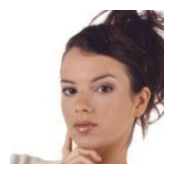

In [159]:
display(dataset[42][0])

Train [5.510M params]: 100 epochs took 2321.03 sec, train loss 0.004918, val loss 0.000000


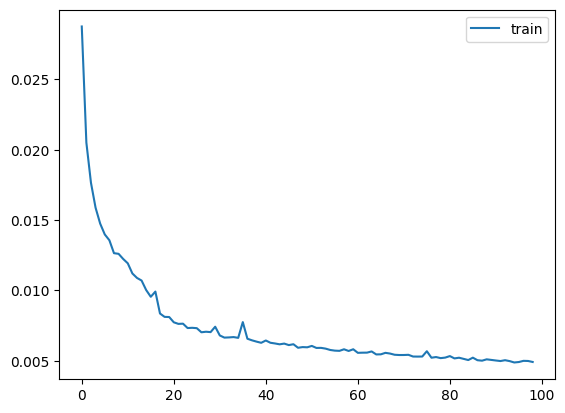

In [163]:
net = FaceNet().to(device)
trainer.train(net, D.DataLoader(dataset, batch_size=128, shuffle=True), batch_limit=100, epochs=100)

<Figure size 400x200 with 0 Axes>

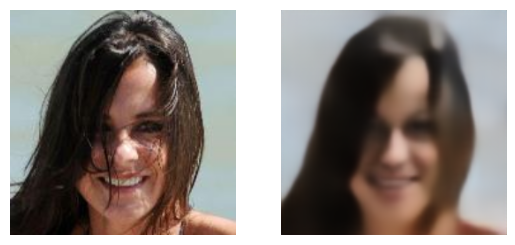

<Figure size 400x200 with 0 Axes>

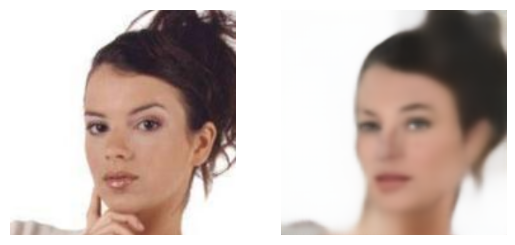

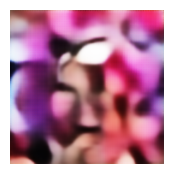

In [180]:
e1 = net.encoder(dataset[5][0].to(device))
y1 = net.decoder(e1)
display2(dataset[5][0], y1.cpu().detach())

e2 = net.encoder(dataset[42][0].to(device))
y2 = net.decoder(e2)
display2(dataset[42][0], y2.cpu().detach())

y12 = net.decoder(torch.randn(256).to(device))
display(y12.cpu().detach())